# Lecture 5: Data Wrangling with Census Data

Often, real-world data isn't in quite the correct format! Sometimes data is in the wrong units, sometimes there are missing values, and sometimes very high/very low values.

Addressing these challenges in order to answer research questions is often referred to as **data wrangling**. Let's walk through an example of how to wrangle some data!

Let's use the Census Public Use Microdata File once again to ask a question:

- **What percentage of their income do households spend on housing each month?**

This question is super important - if households have to spend too much of their money on housing, they won't have any money left over for other things like food, clothes, savings, etc!

Statistics Canada calculates this "shelter-cost-to-income ratio" for each household using by the following formula:

$${\text{Shelter-Cost-to-Income Ratio}} = 100\times \frac{\text{Monthly Shelter Cost}}{\text{Monthly Household Income}} $$

## Step 1: Load Census PUMF Data

Let's begin by importing pandas and reading in our census data:

In [2]:
import pandas as pd

pumf_data = pd.read_csv("pumf_housing_income.csv")

pumf_data.head()

,HH_ID,PP_ID,AGEGRP,CMA,TENUR,TOTINC,SHELCO,WEIGHT
0,1,11101,11,999,2,12000,200,100.417608
1,2,21101,11,999,1,61000,400,100.111806
2,2,21102,11,999,1,37000,400,100.111806
3,3,31101,11,933,1,34000,700,100.481175
4,3,31102,11,933,1,63000,700,100.481175


## Step 2: Subset data

For this example, we will explore the following columns:

   + `HH_ID`: unique household identifier 
   + `CMA`: metro area
   + `TOTINC`: total individual annual income
   + `SHELCO`: monthly household shelter cost 

Just like last week, let's create a subset of `pumf_data` with only these columns!

In [3]:
important_columns = [
    "HH_ID", # Household ID
    "CMA", # Metro Area
    "TOTINC", # Total income
    "SHELCO" # Shelter cost
]

important_columns = ["HH_ID", "CMA", "TOTINC", "SHELCO"] 

subset_pumf_data = pumf_data[important_columns]

subset_pumf_data.head()

,HH_ID,CMA,TOTINC,SHELCO
0,1,999,12000,200
1,2,999,61000,400
2,2,999,37000,400
3,3,933,34000,700
4,3,933,63000,700


## Step 3: Rename columns

Let's use the `rename` function to rename columns to something more intuitive:

In [4]:
new_column_names = {
    "HH_ID": "Household ID",
    "CMA": "Metro Area",
    "TOTINC": "Annual Income",
    "SHELCO": "Monthly Housing Costs"
}
                    
subset_pumf_data = subset_pumf_data.rename(columns = new_column_names)

subset_pumf_data.head()

,Household ID,Metro Area,Annual Income,Monthly Housing Costs
0,1,999,12000,200
1,2,999,61000,400
2,2,999,37000,400
3,3,933,34000,700
4,3,933,63000,700


## Step 4: Investigate the data and address any issues

We can use `.describe()` to look at the specific columns we're interested in. 

In this case, let's look specifically at `Annual Income` and `Monthly Housing Costs`:

In [5]:
subset_pumf_data[["Annual Income", "Monthly Housing Costs"]].describe()

,Annual Income,Monthly Housing Costs
count,3.619150e+05,361915.000000
mean,1.947173e+07,1588.663753
std,3.954027e+07,1025.500641
min,-5.000000e+04,0.000000
25%,2.700000e+04,800.000000
50%,5.200000e+04,1400.000000
75%,1.200000e+05,2129.000000
max,1.000000e+08,4817.000000


`pandas` automatically displays very large numbers and very small numbers in **scientific notation** (for example, 1+e05 instead of 100,000). This is difficult to interpret! 

We can change the default options within `pandas` so that it display floats (decimal numbers) as full numbers with two decimal places for the rest of this session:

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

Let's try this again:

In [7]:
subset_pumf_data[["Annual Income", "Monthly Housing Costs"]].describe()

,Annual Income,Monthly Housing Costs
count,361915.00,361915.00
mean,19471725.52,1588.66
std,39540274.21,1025.50
min,-50000.00,0.00
25%,27000.00,800.00
50%,52000.00,1400.00
75%,120000.00,2129.00
max,99999999.00,4817.00


`.describe()` summarizes each of our columns with numeric data. In this case, we are particularly interested in `Annual Income` and `Monthly Housing Costs`. Pay particular attention to the `min` and `max` values for each variable!

- `Monthly Housing Costs` looks good: the minimum is \\$0 and the maximum is \\$4,817, which are both plausible for monthly housing costs.

- For `Annual Income`, the minimum value is -\\$50,000, and the maximum value is \\$99,999,999. This doesn't seem very believable!

- According to the <a href="2021 Census Hierarchical PUMF User Guide_V2.pdf" target="_blank">codebook</a>, the value 99,999,999 is a **placeholder** value for people who are younger than 15 years old, and aren't expected to have any income!

- There is also another placeholder value (88,888,888) for values that are simply *missing*, likely because someone didn't answer that question on the survey.

    - We should **replace** any cases of these values with `np.nan`, because those aren't actual incomes!

In [8]:
import numpy as np

subset_pumf_data["Annual Income"] = subset_pumf_data["Annual Income"].replace([88888888, 99999999], np.nan)

Now, let's look at the total number of rows (using `len()`) and the total number of values in `Actual Income` that are *not* NaN. We can do this by using the function `notna()`:

In [9]:
n_rows = len(subset_pumf_data)
n_actual_income = subset_pumf_data["Annual Income"].notna().sum()

# Count original number of rows
print(f"The total number of rows is: {n_rows}")

# Count number of values where annual income is a real value
print(f"The total number of rows with an actual income is: {n_actual_income}")

# Share of rows where annual income is a real value
print(f"The share of rows with an actual income is: {round(100*(n_actual_income/n_rows))}%")

The total number of rows is: 361915
The total number of rows with an actual income is: 291597
The share of rows with an actual income is: 81%


Now, let's use `.describe()` to check the values in our columns again:

In [10]:
subset_pumf_data[["Annual Income", "Monthly Housing Costs"]].describe()

,Annual Income,Monthly Housing Costs
count,291597.00,361915.00
mean,54941.32,1588.66
std,64980.38,1025.50
min,-50000.00,0.00
25%,23000.00,800.00
50%,41000.00,1400.00
75%,68000.00,2129.00
max,1039418.00,4817.00


Now, our maximum income value is \\$1,039,418. This is much more believable!

There are also negative incomes, but we'll deal with those later.

## Step 5: Use .groupby to summarize household incomes

Right now, we have records for **individual people** - notice how there are multiple records for Households 2 and 3: 

In [11]:
subset_pumf_data.head()

,Household ID,Metro Area,Annual Income,Monthly Housing Costs
0,1,999,12000.00,200
1,2,999,61000.00,400
2,2,999,37000.00,400
3,3,933,34000.00,700
4,3,933,63000.00,700


The thing is, we need to know the total amount of income that each *household* is making in total!

Let's use `.groupby()` to group our data frame **by household**. This creates a `DataFrameGroupBy` object:

In [12]:
grouped_by_hh = subset_pumf_data.groupby("Household ID")

type(grouped_by_hh)

pandas.core.groupby.generic.DataFrameGroupBy

Then, we can add up the total income for each household, by taking the `Annual Income` column from this grouped object and calculating the `.sum()`:

In [13]:
grouped_by_hh["Annual Income"].sum()

Household ID
1         12000.00
2         98000.00
3         97000.00
4        131000.00
5         14000.00
            ...   
149785    87000.00
149786    44000.00
149787    63000.00
149788   127000.00
149789   115000.00
Name: Annual Income, Length: 149789, dtype: float64

- By default, results from a groupby object will print as a pandas Series. If we want a pandas data frame instead, we should include the argument `as_index = False` inside of the `groupby()` function.

- Let's also include `Metro Area` and `Monthly Housing Costs` inside our `.groupby()` command, because those values will always be the same for each household member: 
    - Each household member lives within the same Metro Area, and each household member has the same overall housing cost.

In [14]:
grouped_by_hh = subset_pumf_data.groupby(["Household ID", "Metro Area", "Monthly Housing Costs"], as_index = False)

pumf_summary = grouped_by_hh["Annual Income"].sum()

pumf_summary

,Household ID,Metro Area,Monthly Housing Costs,Annual Income
0,1,999,200,12000.00
1,2,999,400,98000.00
2,3,933,700,97000.00
3,4,535,800,131000.00
4,5,462,800,14000.00
...,...,...,...,...
149784,149785,999,600,87000.00
149785,149786,999,300,44000.00
149786,149787,999,500,63000.00
149787,149788,999,1300,127000.00


## Step 6: Remove zero/negative incomes

As a reminder, we are trying to calculate the following formula:

$${\text{Shelter-Cost-to-Income Ratio}} = 100\times \frac{\text{Monthly Shelter Cost}}{\text{Monthly Household Income}} $$

- When calculating the percentage of income spent on rent, Statistics Canada advises removing any households that have incomes that are negative or \\$0. 

- It is impossible to divide something by zero, and dividing a negative number doesn't make any sense - you can't pay negative income on rent!


Let's create a boolean that only contains incomes greater than zero, and then use that boolean to filter our `pumf_summary` data frame:

In [15]:
# Create a boolean for positive incomes
positive_income = pumf_summary["Annual Income"] > 0

# Filter subset_pumf_data using our `actual_income` boolean
pumf_summary = pumf_summary[positive_income]

# Describe Annual Income column
pumf_summary[["Annual Income"]].describe()

,Annual Income
count,149114.00
mean,107450.59
std,103153.55
min,1.00
25%,48000.00
50%,84000.00
75%,135000.00
max,1541739.00


Now, the minimum household income is \\$1!

## Step 7: Convert Annual Income to Monthly Income

Currently, we have annual income and monthly housing costs. To compare the two, we need to change annual income so that it is also monthly! Let's create a new column called `Monthly Household Income`, where the annual income is divided by 12.



To create a new column, we can put the name of the new column in `[]` brackets, and then provide the new values you want that column to have.

The calculation of the values is done **element-wise**. This means all values in the original column (`Annual Income`) are divided by 12. You do not need to use a loop to iterate each of the rows!

In [16]:
pumf_summary["Monthly Household Income"] = pumf_summary["Annual Income"] / 12

pumf_summary.head()

/var/folders/jz/02frwszj4y3c54slttlf77480000gp/T/ipykernel_7063/4213675144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pumf_summary["Monthly Household Income"] = pumf_summary["Annual Income"] / 12


,Household ID,Metro Area,Monthly Housing Costs,Annual Income,Monthly Household Income
0,1,999,200,12000.00,1000.00
1,2,999,400,98000.00,8166.67
2,3,933,700,97000.00,8083.33
3,4,535,800,131000.00,10916.67
4,5,462,800,14000.00,1166.67


## Step 8: Calculate Shelter-Cost-to-Income Ratio

Finally, we are ready to calculate how much of each household's annual income is spent on housing! Let's create an additional column that divides `Monthly Housing Costs` by `Monthly Household Income`:

$${\text{Shelter-Cost-to-Income Ratio}} = 100\times \frac{\text{Monthly Shelter Cost}}{\text{Monthly Household Income}} $$


In [17]:
pumf_summary["Shelter-Cost-To-Income Ratio"] = 100*(pumf_summary["Monthly Housing Costs"]/pumf_summary["Monthly Household Income"])

pumf_summary.head()

/var/folders/jz/02frwszj4y3c54slttlf77480000gp/T/ipykernel_7063/1087858151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pumf_summary["Shelter-Cost-To-Income Ratio"] = 100*(pumf_summary["Monthly Housing Costs"]/pumf_summary["Monthly Household Income"])


,Household ID,Metro Area,Monthly Housing Costs,Annual Income,Monthly Household Income,Shelter-Cost-To-Income Ratio
0,1,999,200,12000.00,1000.00,20.00
1,2,999,400,98000.00,8166.67,4.90
2,3,933,700,97000.00,8083.33,8.66
3,4,535,800,131000.00,10916.67,7.33
4,5,462,800,14000.00,1166.67,68.57


Household 1 spends 20% of its annual income on housing, Household 2 spends 4.9% of its annual income on housing, etc.

## Step 9: "Topcoding" high values

If we use `.describe()` on our new column, there is something strange - some households appear to be paying way more than 100% of their income on housing! That shouldn't be possible.

In [18]:
pumf_summary[["Shelter-Cost-To-Income Ratio"]].describe()

,Shelter-Cost-To-Income Ratio
count,149114.00
mean,1958.59
std,67715.79
min,0.00
25%,10.32
50%,17.28
75%,27.50
max,5780400.00


Let's investigate the highest value to see what's going on:

In [19]:
pumf_summary[pumf_summary["Shelter-Cost-To-Income Ratio"] == 5780400]

,Household ID,Metro Area,Monthly Housing Costs,Annual Income,Monthly Household Income,Shelter-Cost-To-Income Ratio
72033,72034,933,4817,1.00,0.08,5780400.00
86493,86494,933,4817,1.00,0.08,5780400.00
106451,106452,933,4817,1.00,0.08,5780400.00


It looks like this is happening because there are some households with an Annual Income of only $1! This is resulting in extremely high values that don't make any sense. Realistically, households can only spend 100% of their income on rent. 

To fix this, we will need to "topcode" this variable so that any values greater than 100% are automatically reset to be 100%.

In [20]:
pumf_summary.loc[pumf_summary["Shelter-Cost-To-Income Ratio"] > 100, "Shelter-Cost-To-Income Ratio"] = 100

If we `.describe()` this column again, we can see that the maximum value is now 100%!

In [21]:
pumf_summary["Shelter-Cost-To-Income Ratio"].describe()

count   149114.00
mean        22.52
std         19.45
min          0.00
25%         10.32
50%         17.28
75%         27.50
max        100.00
Name: Shelter-Cost-To-Income Ratio, dtype: float64

## Step 10: Visualize our data

Let's create a boxplot to visualize our new `Shelter-Cost-To-Income Ratio` variable. This provides us with information about our overall distribution, as well as where the median, 1st quartile, and 3rd quartile are located:

<Axes: >

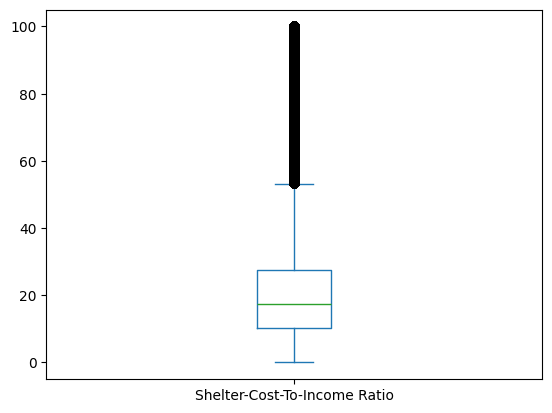

In [22]:
pumf_summary.plot.box(column = "Shelter-Cost-To-Income Ratio")

We can also break this down into different metro areas!

Shelter-Cost-To-Income Ratio    Axes(0.125,0.11;0.775x0.77)
dtype: object

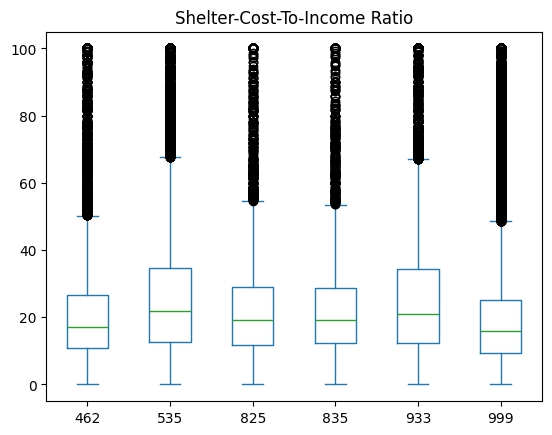

In [23]:
pumf_summary.plot.box(column = "Shelter-Cost-To-Income Ratio", by = "Metro Area")

It isn't very intuitive to use the internal numeric codes for these metro areas. Let's use `.loc()` to change their names. For example, we can change the value of `Metro Area` to "Montreal" anytime that column is equal to 462:

In [24]:
pumf_summary.loc[pumf_summary["Metro Area"] == 462, "Metro Area"] = "Montreal"

pumf_summary.head()

/var/folders/jz/02frwszj4y3c54slttlf77480000gp/T/ipykernel_7063/1272536116.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Montreal' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pumf_summary.loc[pumf_summary["Metro Area"] == 462, "Metro Area"] = "Montreal"


,Household ID,Metro Area,Monthly Housing Costs,Annual Income,Monthly Household Income,Shelter-Cost-To-Income Ratio
0,1,999,200,12000.00,1000.00,20.00
1,2,999,400,98000.00,8166.67,4.90
2,3,933,700,97000.00,8083.33,8.66
3,4,535,800,131000.00,10916.67,7.33
4,5,Montreal,800,14000.00,1166.67,68.57


Let's change all the rest of the `Metro Area` labels

In [25]:
pumf_summary.loc[pumf_summary["Metro Area"] == 535, "Metro Area"] = "Toronto"

pumf_summary.loc[pumf_summary["Metro Area"] == 825, "Metro Area"] = "Calgary"

pumf_summary.loc[pumf_summary["Metro Area"] == 835, "Metro Area"] = "Edmonton"

pumf_summary.loc[pumf_summary["Metro Area"] == 933, "Metro Area"] = "Vancouver"

pumf_summary.loc[pumf_summary["Metro Area"] == 999, "Metro Area"] = "Elsewhere"

Finally, let's redo our plot!

Shelter-Cost-To-Income Ratio    Axes(0.125,0.11;0.775x0.77)
dtype: object

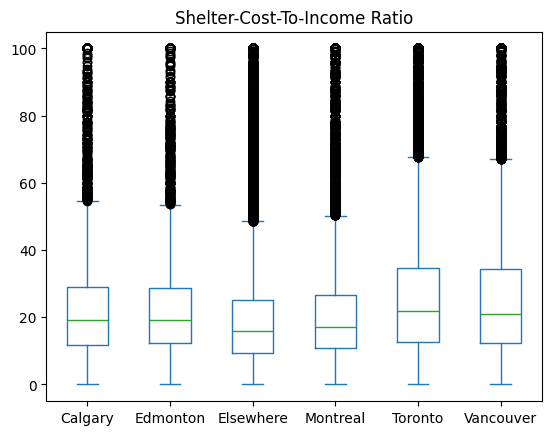

In [26]:
pumf_summary.plot.box(column = "Shelter-Cost-To-Income Ratio", by = "Metro Area")